In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from datetime import datetime
from google.colab import files
import io
import joblib
import ipywidgets as widgets
from IPython.display import display

In [ ]:
# Step 2: Loading Data
df = pd.read_excel("dats_sets_hotel_gardenia.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12521 entries, 0 to 12520
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ReqID                               12521 non-null  int64         
 1   Booking date                        12521 non-null  datetime64[ns]
 2   Check in Date                       12521 non-null  datetime64[ns]
 3   Number of Customers                 12521 non-null  int64         
 4   Family (Y/N)                        12521 non-null  object        
 5   Age Group                           12521 non-null  object        
 6   Booking Channel                     12521 non-null  object        
 7   Stay Duration (nights)              12521 non-null  int64         
 8   Spending Level                      12521 non-null  object        
 9   Purpose of Travel                   12521 non-null  object        
 10  Discount Applied      

In [ ]:
df['Membership Level'].fillna('Non-Member', inplace=True)
df['Membership Level']

<ipython-input-21-3910713fc9a9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Membership Level'].fillna('Non-Member', inplace=True)


,Membership Level
0,Gold
1,Non-Member
2,Silver
3,Non-Member
4,Non-Member
...,...
12516,Silver
12517,Platinum
12518,Non-Member
12519,Non-Member


In [ ]:
df['Special Request'].fillna('No', inplace=True)
df['Special Request']

<ipython-input-22-25e4bdc4fe85>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Special Request'].fillna('No', inplace=True)


,Special Request
0,Early Check-in
1,Early Check-in
2,No
3,No
4,No
...,...
12516,No
12517,Extra Bed
12518,Extra Bed
12519,Late Check-out


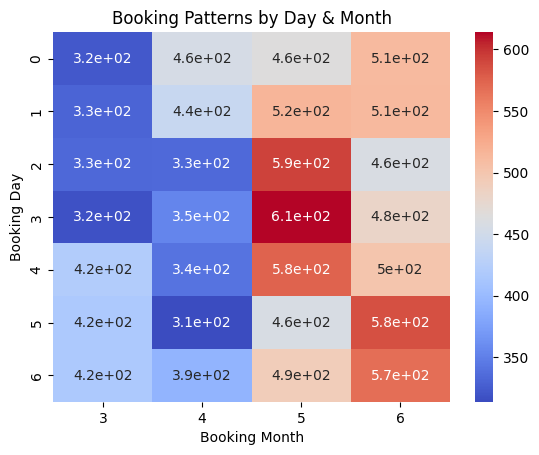

In [ ]:
# Step 3: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

df['Booking Month'] = df['Booking date'].dt.month
df['Booking Day'] = df['Booking date'].dt.dayofweek  # 0=Monday, 6=Sunday

pivot = df.pivot_table(index='Booking Day', columns='Booking Month', aggfunc='size', fill_value=0)
sns.heatmap(pivot, cmap='coolwarm', annot=True)
plt.title('Booking Patterns by Day & Month')
plt.show()

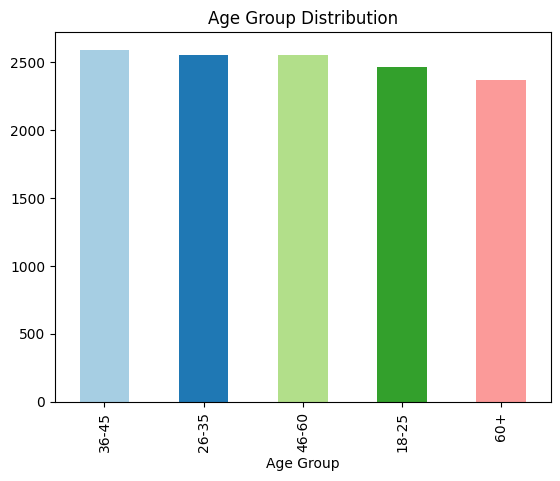

In [ ]:
df['Age Group'].value_counts().plot(kind='bar', color=plt.cm.Paired(range(len(df['Age Group'].value_counts()))))
plt.title('Age Group Distribution')
plt.show()

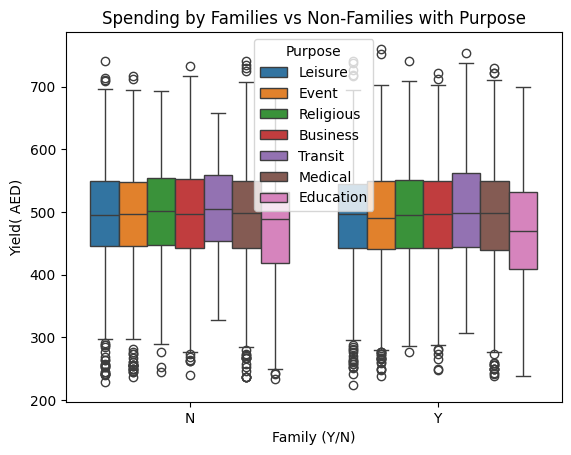

In [ ]:
sns.boxplot(x='Family (Y/N)', y='Yield( AED)', hue='Purpose of Travel', data=df)
plt.title('Spending by Families vs Non-Families with Purpose')
plt.legend(title='Purpose')
plt.show()

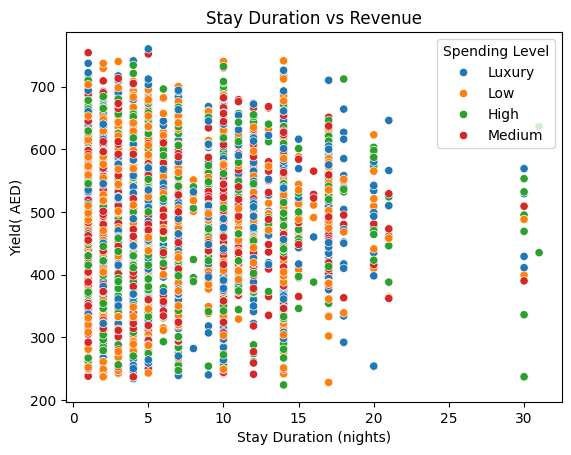

In [ ]:
sns.scatterplot(x='Stay Duration (nights)', y='Yield( AED)', hue='Spending Level', data=df)
plt.title('Stay Duration vs Revenue')
plt.show()

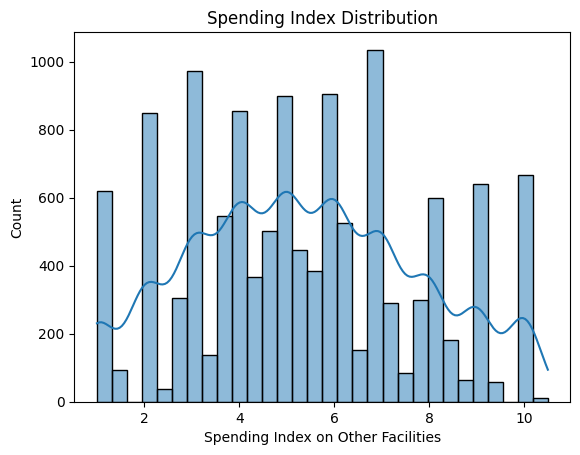

In [ ]:
sns.histplot(df['Spending Index on Other Facilities'], kde=True, bins=30)
plt.title('Spending Index Distribution')
plt.show()

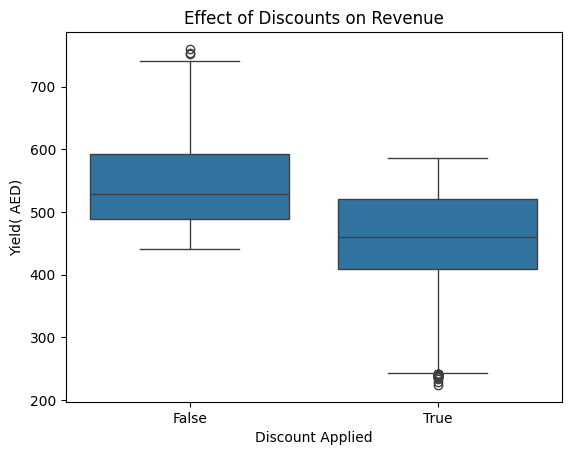

In [ ]:
sns.boxplot(x='Discount Applied', y='Yield( AED)', data=df)
plt.title('Effect of Discounts on Revenue')
plt.show()

<ipython-input-29-4c35aa36bee8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Booking Channel', y='Rating by customer', data=df, palette='viridis')


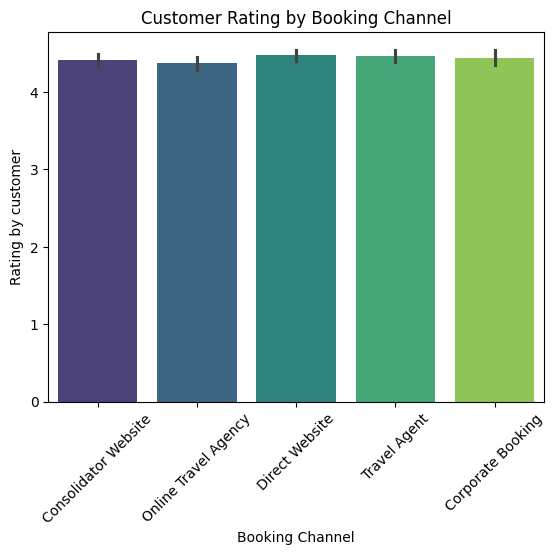

In [ ]:
sns.barplot(x='Booking Channel', y='Rating by customer', data=df, palette='viridis')
plt.title('Customer Rating by Booking Channel')
plt.xticks(rotation=45)
plt.show()

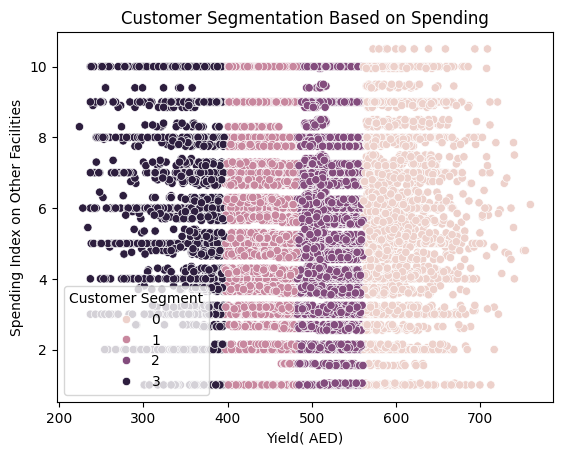

In [ ]:
from sklearn.cluster import KMeans

X = df[['Stay Duration (nights)', 'Yield( AED)', 'Spending Index on Other Facilities']].dropna()
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
df['Customer Segment'] = kmeans.labels_

sns.scatterplot(x='Yield( AED)', y='Spending Index on Other Facilities', hue='Customer Segment', data=df) # Add data=df
plt.title('Customer Segmentation Based on Spending')
plt.show()

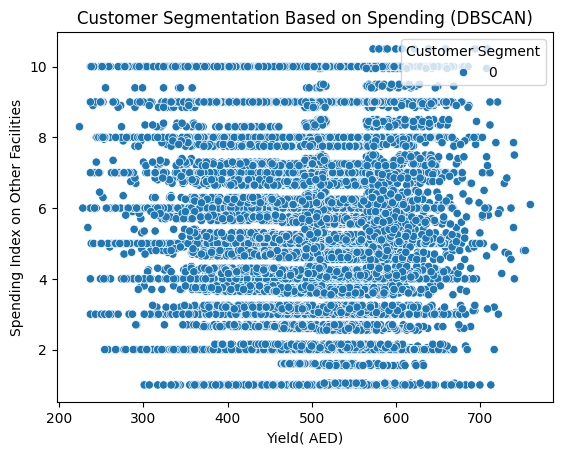

In [ ]:
from sklearn.cluster import DBSCAN

X = df[['Stay Duration (nights)', 'Yield( AED)', 'Spending Index on Other Facilities']].dropna()
dbscan = DBSCAN(eps=50, min_samples=5).fit(X)  # Customize eps and min_samples as needed
df['Customer Segment'] = dbscan.labels_

sns.scatterplot(x='Yield( AED)', y='Spending Index on Other Facilities', hue='Customer Segment', data=df)
plt.title('Customer Segmentation Based on Spending (DBSCAN)')
plt.show()

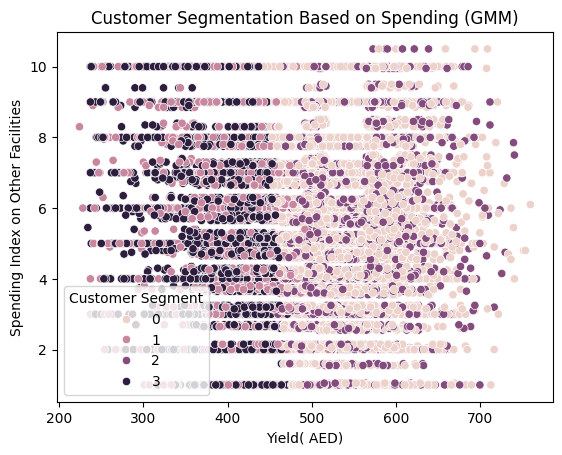

In [ ]:
from sklearn.mixture import GaussianMixture

X = df[['Stay Duration (nights)', 'Yield( AED)', 'Spending Index on Other Facilities']].dropna()
gmm = GaussianMixture(n_components=4, random_state=42).fit(X)
df['Customer Segment'] = gmm.predict(X)  # Predict cluster labels for each data point

sns.scatterplot(x='Yield( AED)', y='Spending Index on Other Facilities', hue='Customer Segment', data=df)
plt.title('Customer Segmentation Based on Spending (GMM)')
plt.show()

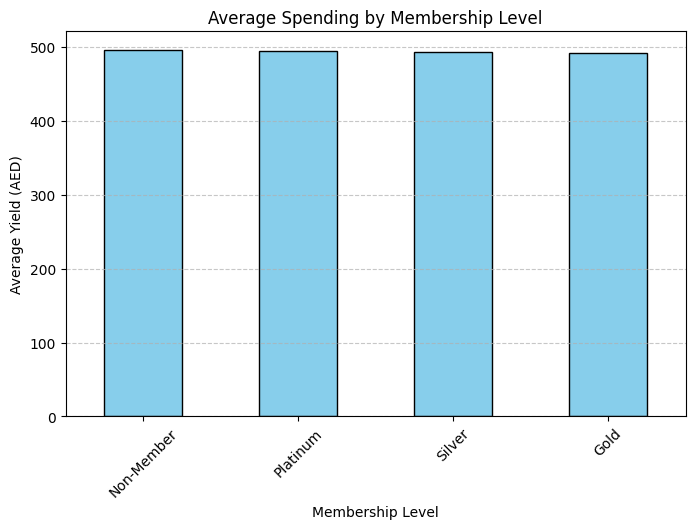

In [ ]:
# Group by 'Membership Level' and calculate average Yield
membership_spending = df.groupby('Membership Level')['Yield( AED)'].mean().sort_values(ascending=False)

# Plot the results
membership_spending.plot(kind='bar', figsize=(8,5), color='skyblue', edgecolor='black')

plt.title('Average Spending by Membership Level')
plt.xlabel('Membership Level')
plt.ylabel('Average Yield (AED)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
#Spending Level Across Memebership

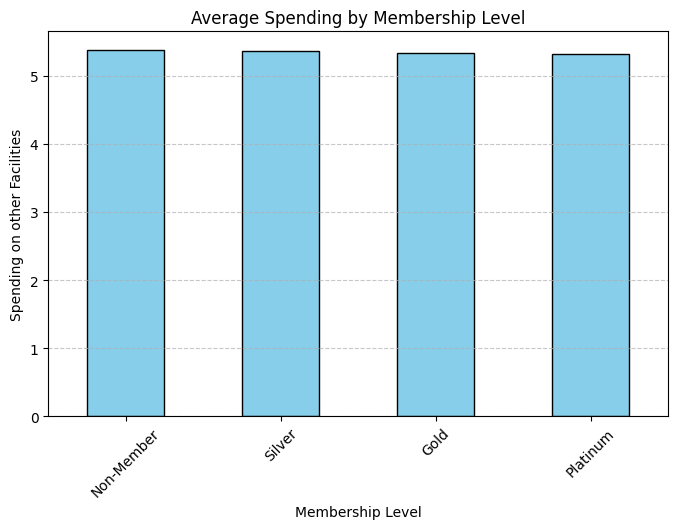

In [ ]:
# Group by 'Membership Level' and calculate average Yield
membership_spending = df.groupby('Membership Level')['Spending Index on Other Facilities'].mean().sort_values(ascending=False)

# Plot the results
membership_spending.plot(kind='bar', figsize=(8,5), color='skyblue', edgecolor='black')

plt.title('Average Spending by Membership Level')
plt.xlabel('Membership Level')
plt.ylabel('Spending on other Facilities')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
#Spending Level Across Memebership

In [ ]:
df.groupby('Membership Level')['Yield( AED)'].mean().reset_index()

,Membership Level,Yield( AED)
0,Gold,491.035585
1,Non-Member,495.868294
2,Platinum,494.796763
3,Silver,492.986709


In [ ]:
# Step 5: Preprocess the dataset
# 5.1: Convert dates to numerical features
#df["Booking date"] = pd.to_datetime(df["Booking date"])
#df["Check in Date"] = pd.to_datetime(df["Check in Date"])
df["Booking Lead Time"] = (df["Check in Date"] - df["Booking date"]).dt.days
#df["Month"] = df["Check in Date"].dt.month
df['month'] = df['Check in Date'].dt.month
df['day_of_week'] = df['Check in Date'].dt.dayofweek
df['quarter'] = df['Check in Date'].dt.quarter
df.drop(columns=["Booking date", "Check in Date","Loyalty Points Used to pay","Special Request",
                       "Asked for Deals/Discount", "Asked for change of room",
                       "Accepted Tour Pack"], inplace=True)



# 5.2: Encode categorical variables
categorical_columns = ["Family (Y/N)", "Age Group", "Booking Channel", "Spending Level",
                       "Purpose of Travel", "Membership Level"]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 5.3: Convert "Discount Applied" to numeric
df["Discount Applied"] = df["Discount Applied"].map({True: 1, False: 0})

In [ ]:
df

,ReqID,Number of Customers,Family (Y/N),Age Group,Booking Channel,Stay Duration (nights),Spending Level,Purpose of Travel,Discount Applied,Membership Level,Yield( AED),Spending Index on Other Facilities,Rating by customer,Booking Month,Booking Day,Customer Segment,Booking Lead Time,month,day_of_week,quarter
0,279001,3,0,1,0,2,2,3,0,0,520,6.25,3,3,0,2,79,6,2,2
1,279002,4,1,0,0,3,1,2,0,1,564,3.15,2,3,1,0,16,3,3,1
2,279003,4,1,1,3,1,2,2,0,3,465,3.10,5,3,2,1,123,7,6,3
3,279004,5,1,2,2,2,0,3,0,1,542,3.55,3,3,2,2,96,7,0,3
4,279005,1,0,2,4,5,1,5,0,1,488,2.15,5,6,6,2,4,7,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12516,288996,2,0,3,3,11,0,5,1,3,422,4.30,6,5,0,1,31,6,3,2
12517,288997,6,1,1,2,1,3,2,0,2,455,4.30,3,6,6,1,31,7,2,3
12518,288998,4,1,0,0,12,2,2,0,1,475,4.10,2,5,0,1,98,8,0,3
12519,288999,5,1,4,4,1,1,6,0,1,653,2.15,3,6,1,0,33,7,6,3


In [ ]:
#Feature Engineering
# Step 7: Compute Factors for Fare Adjustment (Normalized)
# 7.1: Demand Factor (D(t))
df['Demand Factor'] = df['Booking Lead Time'] / df['Booking Lead Time'].max()
df['Demand Factor'] = df['Demand Factor'].fillna(0)

# 7.2: Seasonality Factor (S(t))
peak_season = df['month'].isin([6, 7, 8])
df['Seasonality Factor'] = np.where(peak_season, 1.0, 0.8)
seasonality_range = df['Seasonality Factor'].max() - df['Seasonality Factor'].min()
if seasonality_range != 0:
    df['Seasonality Factor'] = (df['Seasonality Factor'] - df['Seasonality Factor'].min()) / seasonality_range
else:
    df['Seasonality Factor'] = 0

# 7.3: Willingness to Pay (WTP(t))
df['WTP Factor'] = df['Spending Index on Other Facilities'] / df['Spending Index on Other Facilities'].max()
df['WTP Factor'] = df['WTP Factor'].fillna(0)


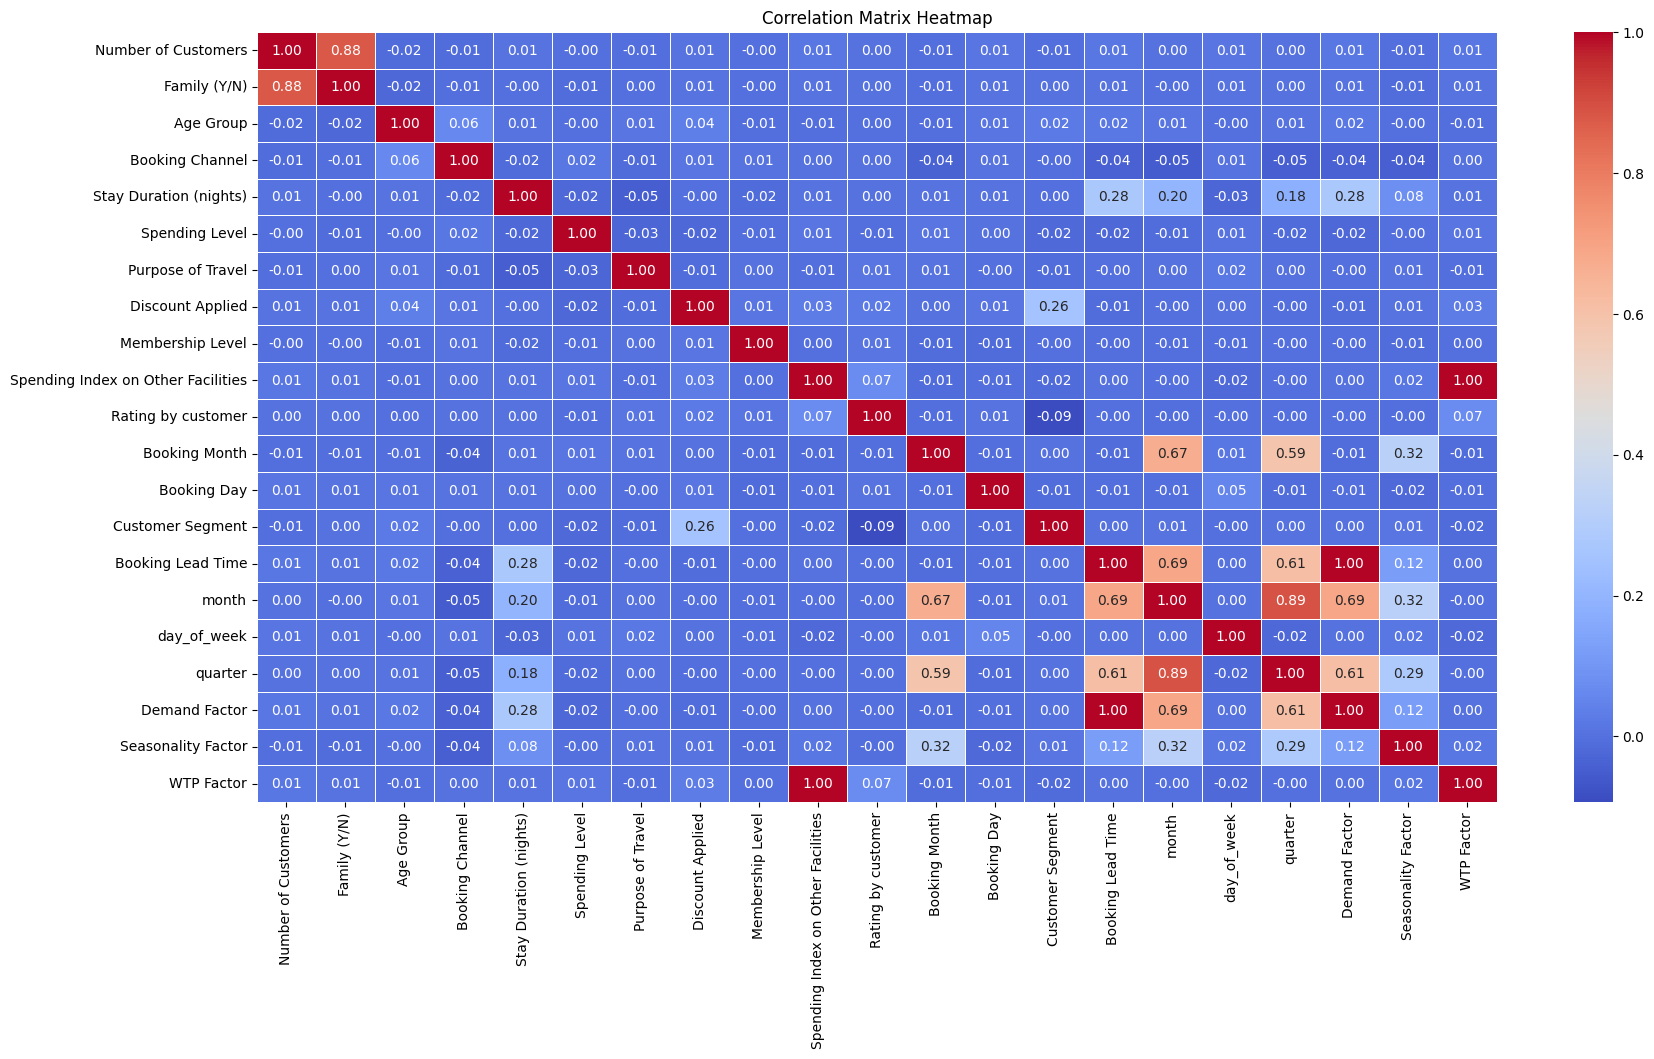

In [ ]:
data  = df.drop(columns=["ReqID","Yield( AED)"])
corr_matrix = data.corr()
# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Iteratively drop variables with highest VIF until all are < 10
while True:
    vif_df = calculate_vif(data)
    max_vif = vif_df['VIF'].max()

    if max_vif < 10:
        break  # Stop if all variables have VIF < 10

    # Drop variable with highest VIF
    feature_to_drop = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
    data = data.drop(columns=[feature_to_drop])
    print(f"Dropped {feature_to_drop} (VIF: {max_vif:.2f})")

# Final VIF results
print("\nFinal VIF Values:")
print(calculate_vif(data))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped Spending Index on Other Facilities (VIF: inf)


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped Booking Lead Time (VIF: inf)
Dropped month (VIF: 352.82)
Dropped quarter (VIF: 65.62)
Dropped Number of Customers (VIF: 20.51)
Dropped Booking Month (VIF: 13.94)

Final VIF Values:
                   Feature       VIF
0             Family (Y/N)  1.957182
1                Age Group  2.900267
2          Booking Channel  3.073160
3   Stay Duration (nights)  2.942733
4           Spending Level  2.635383
5        Purpose of Travel  3.101591
6         Discount Applied  2.504940
7         Membership Level  2.696743
8       Rating by customer  4.928394
9              Booking Day  3.092307
10        Customer Segment  3.275089
11             day_of_week  3.081313
12           Demand Factor  3.665288
13      Seasonality Factor  2.541396
14              WTP Factor  5.246919


In [ ]:
col = data.columns.tolist()
col.append("Yield( AED)")
col

['Family (Y/N)',
 'Age Group',
 'Booking Channel',
 'Stay Duration (nights)',
 'Spending Level',
 'Purpose of Travel',
 'Discount Applied',
 'Membership Level',
 'Rating by customer',
 'Booking Day',
 'Customer Segment',
 'day_of_week',
 'Demand Factor',
 'Seasonality Factor',
 'WTP Factor',
 'Yield( AED)']

In [ ]:
data =  df[col]

In [ ]:
data

,Family (Y/N),Age Group,Booking Channel,Stay Duration (nights),Spending Level,Purpose of Travel,Discount Applied,Membership Level,Rating by customer,Booking Day,Customer Segment,day_of_week,Demand Factor,Seasonality Factor,WTP Factor,Yield( AED)
0,0,1,0,2,2,3,0,0,3,0,2,2,0.564286,1.0,0.595238,520
1,1,0,0,3,1,2,0,1,2,1,0,3,0.114286,0.0,0.300000,564
2,1,1,3,1,2,2,0,3,5,2,1,6,0.878571,1.0,0.295238,465
3,1,2,2,2,0,3,0,1,3,2,2,0,0.685714,1.0,0.338095,542
4,0,2,4,5,1,5,0,1,5,6,2,3,0.028571,1.0,0.204762,488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12516,0,3,3,11,0,5,1,3,6,0,1,3,0.221429,1.0,0.409524,422
12517,1,1,2,1,3,2,0,2,3,6,1,2,0.221429,1.0,0.409524,455
12518,1,0,0,12,2,2,0,1,2,0,1,0,0.700000,1.0,0.390476,475
12519,1,4,4,1,1,6,0,1,3,1,0,6,0.235714,1.0,0.204762,653


Epoch 1/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0344 - mae: 0.1400 - val_loss: 0.0085 - val_mae: 0.0767
Epoch 2/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0085 - mae: 0.0751 - val_loss: 0.0027 - val_mae: 0.0403
Epoch 3/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0047 - mae: 0.0527 - val_loss: 0.0025 - val_mae: 0.0385
Epoch 4/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0039 - mae: 0.0481 - val_loss: 0.0021 - val_mae: 0.0360
Epoch 5/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0032 - mae: 0.0436 - val_loss: 0.0026 - val_mae: 0.0392
Epoch 6/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0029 - mae: 0.0418 - val_loss: 0.0022 - val_mae: 0.0354
Epoch 7/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0028 - mae: 0.0406 - val_loss: 0.0023 - val_mae: 0.0361
Epoch 8/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0026 - mae: 0.0391 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 9/50
1252/1252 ━━━━━━━━━━━━━━━━━━

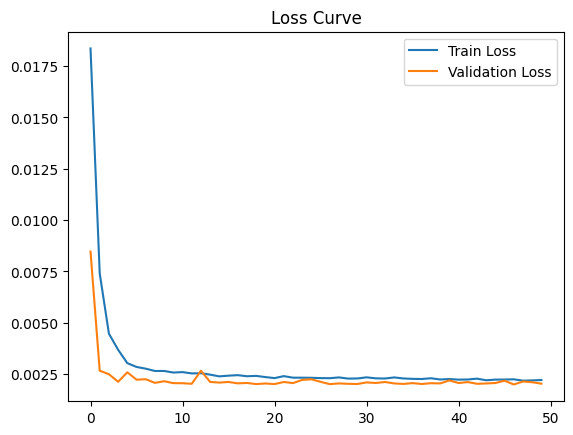

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scale Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create X (features) and y (target)
X = scaled_data[:, :-1]  # All columns except target
y = scaled_data[:, -1]   # Target column

# Reshape X for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))  # 1 timestep

# Split into Train & Test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, activation='relu')),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])
# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = model.predict(X_test)

num_features = scaled_data.shape[1]  # Get the original number of features
y_test_inv = scaler.inverse_transform(np.c_[np.zeros((len(y_test), num_features - 1)), y_test])[:, -1]
y_pred_inv = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), num_features - 1)), y_pred])[:, -1]

# Metrics Calculation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"📊 Model Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# Plot Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


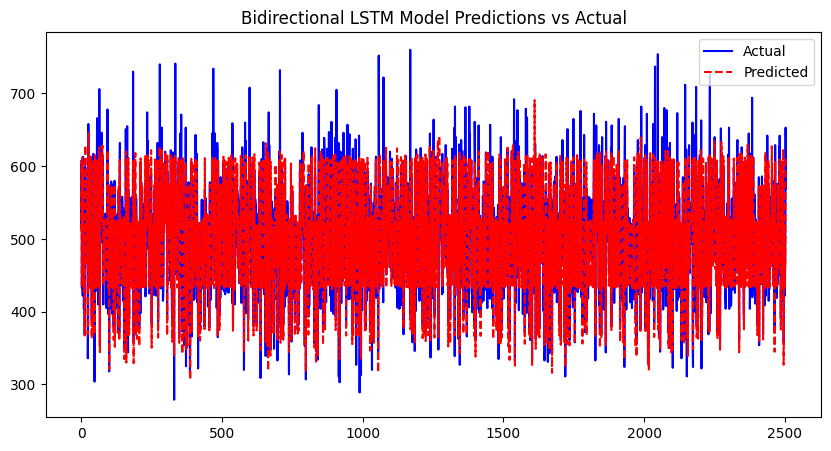

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title("Bidirectional LSTM Model Predictions vs Actual")
plt.show()

Epoch 1/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0414 - mae: 0.1511 - val_loss: 0.0088 - val_mae: 0.0766
Epoch 2/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0092 - mae: 0.0775 - val_loss: 0.0036 - val_mae: 0.0462
Epoch 3/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0042 - mae: 0.0494 - val_loss: 0.0024 - val_mae: 0.0374
Epoch 4/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0033 - mae: 0.0445 - val_loss: 0.0025 - val_mae: 0.0387
Epoch 5/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0031 - mae: 0.0420 - val_loss: 0.0024 - val_mae: 0.0366
Epoch 6/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0027 - mae: 0.0401 - val_loss: 0.0023 - val_mae: 0.0361
Epoch 7/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0026 - mae: 0.0397 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 8/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0025 - mae: 0.0385 - val_loss: 0.0024 - val_mae: 0.0375
Epoch 9/50
1252/1252 ━━━━━━━━━━━━━━━

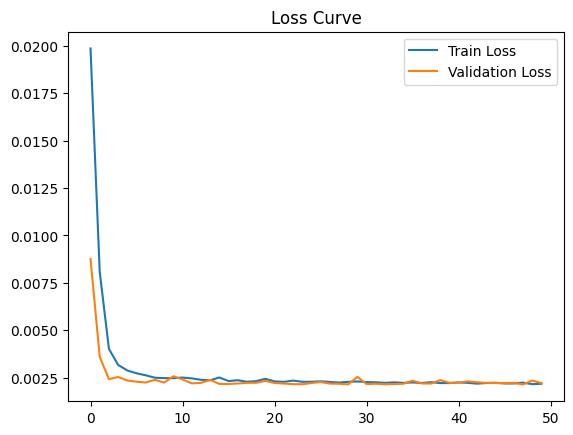

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Scale Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create X (features) and y (target)
X = scaled_data[:, :-1]  # All columns except target
y = scaled_data[:, -1]   # Target column

# Reshape X for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))  # 1 timestep

# Split into Train, Validation, & Test datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split 50/50 between val and test

# Build LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, activation='relu')),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])

# Train Model with Validation Dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val), verbose=1)

# Predictions
y_pred = model.predict(X_test)

num_features = scaled_data.shape[1]  # Get the original number of features
y_test_inv = scaler.inverse_transform(np.c_[np.zeros((len(y_test), num_features - 1)), y_test])[:, -1]
y_pred_inv = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), num_features - 1)), y_pred])[:, -1]

# Metrics Calculation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"📊 Model Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# Plot Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()